# Modelos de Regresion

Utilizando modelos de regresion, buscamos predecir la satisfaccion del cliente y los retrasos en entregas.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Abrir CSV
df = pd.read_csv('dataset/cleaned_orders.csv')
df['delivery_delayed'] =  df['delivery_delayed'].astype(int)
df.drop(columns=['has_comment', 'has_title'], inplace=True)
df = df.dropna()

# Separar en test y train con 30/70
dftrain, dftest = train_test_split(
    df,
    test_size=0.3,
    stratify=df['review_score'],
    random_state=42
)

df.head(15)


,estimated_delivery_days,delivery_days,delivery_delta,delivery_delayed,avg_product_price,total_order_price,item_count,order_freight_value,avg_product_weight,total_order_weight_g,...,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,15,8,7,0,29.99,29.99,1,8.72,500.0,500.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,19,13,6,0,118.70,118.70,1,22.76,400.0,400.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,26,9,17,0,159.90,159.90,1,19.22,420.0,420.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,26,13,13,0,45.00,45.00,1,27.20,450.0,450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,12,2,10,0,19.90,19.90,1,8.72,250.0,250.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,22,16,6,0,147.90,147.90,1,27.36,7150.0,7150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,21,9,12,0,59.99,59.99,1,15.17,50.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,41,9,32,0,19.90,19.90,1,16.05,300.0,300.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,24,18,6,0,149.99,149.99,1,19.77,9750.0,9750.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9,21,12,9,0,99.00,198.00,2,30.53,9000.0,18000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Regresion Lineal

### Prediccion Satisfaccion Cliente

Primero, separamos los modelos entre X e Y con la variable objetivo

In [17]:
x_train = dftrain.drop(columns=['review_score'])
y_train = dftrain['review_score']

x_test = dftest.drop(columns=['review_score'])
y_test = dftest['review_score']

Empezando, vamos a realizar una regresion simple con todas las variables

R² Score: 0.178
MSE: 1.36


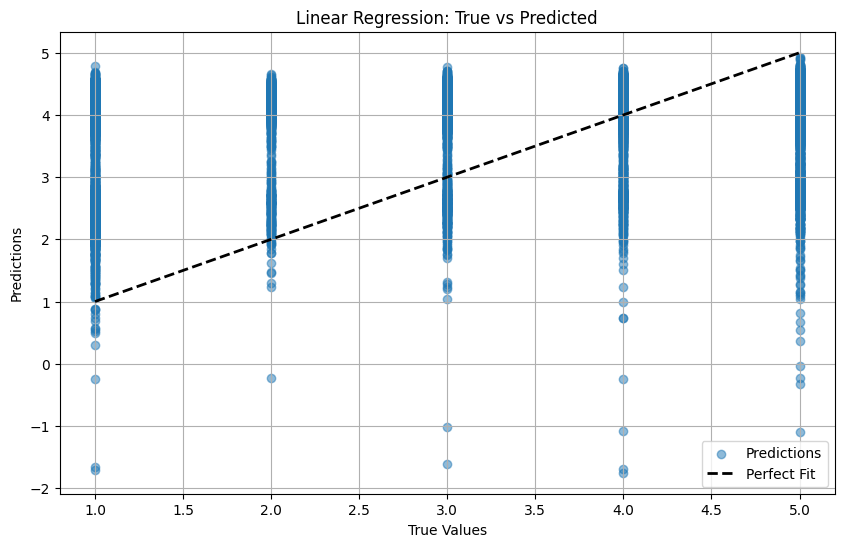

In [18]:
from sklearn.linear_model  import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

model = LinearRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Fit')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Linear Regression: True vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

Dentro del dataset tenemos algunas variables correlacionadas, debido a esto 

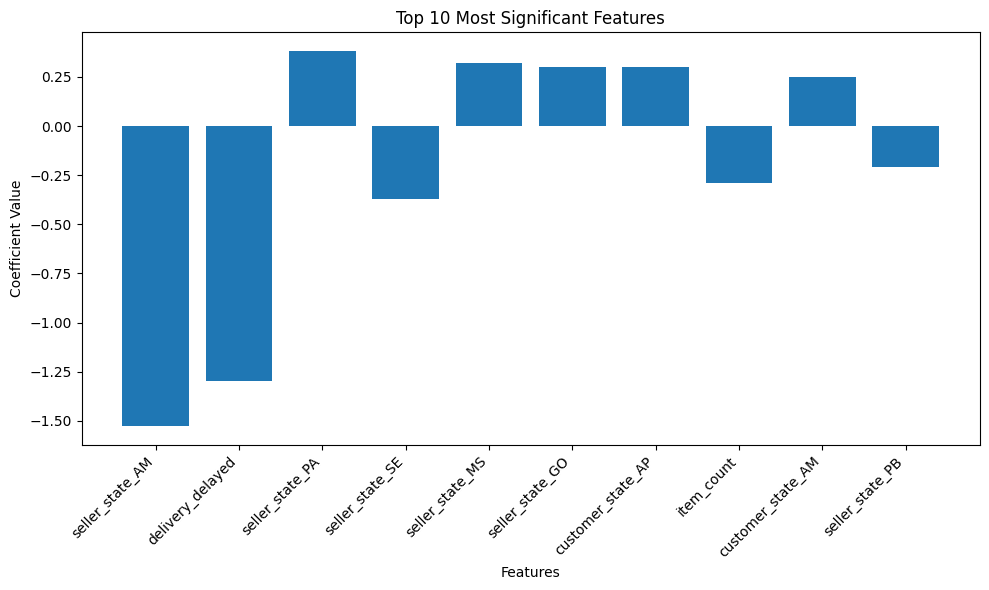

In [19]:
feature_names = list(x_train.columns)

coefficients = model.coef_
feature_coefficient_pairs = list(zip(feature_names, coefficients))
feature_coefficient_pairs = sorted(
    feature_coefficient_pairs, key=lambda x: abs(x[1]), reverse=True
)

top_n = 10
top_features = feature_coefficient_pairs[:top_n]

top_feature_names = [feature[0] for feature in top_features]
top_coefficients = [feature[1] for feature in top_features]

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(top_feature_names, top_coefficients)  # Use top_feature_names directly as x-axis labels
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title(f'Top {top_n} Most Significant Features')
plt.xticks(
    rotation=45, ha='right'
)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Modelo de regresión lineal múltiple


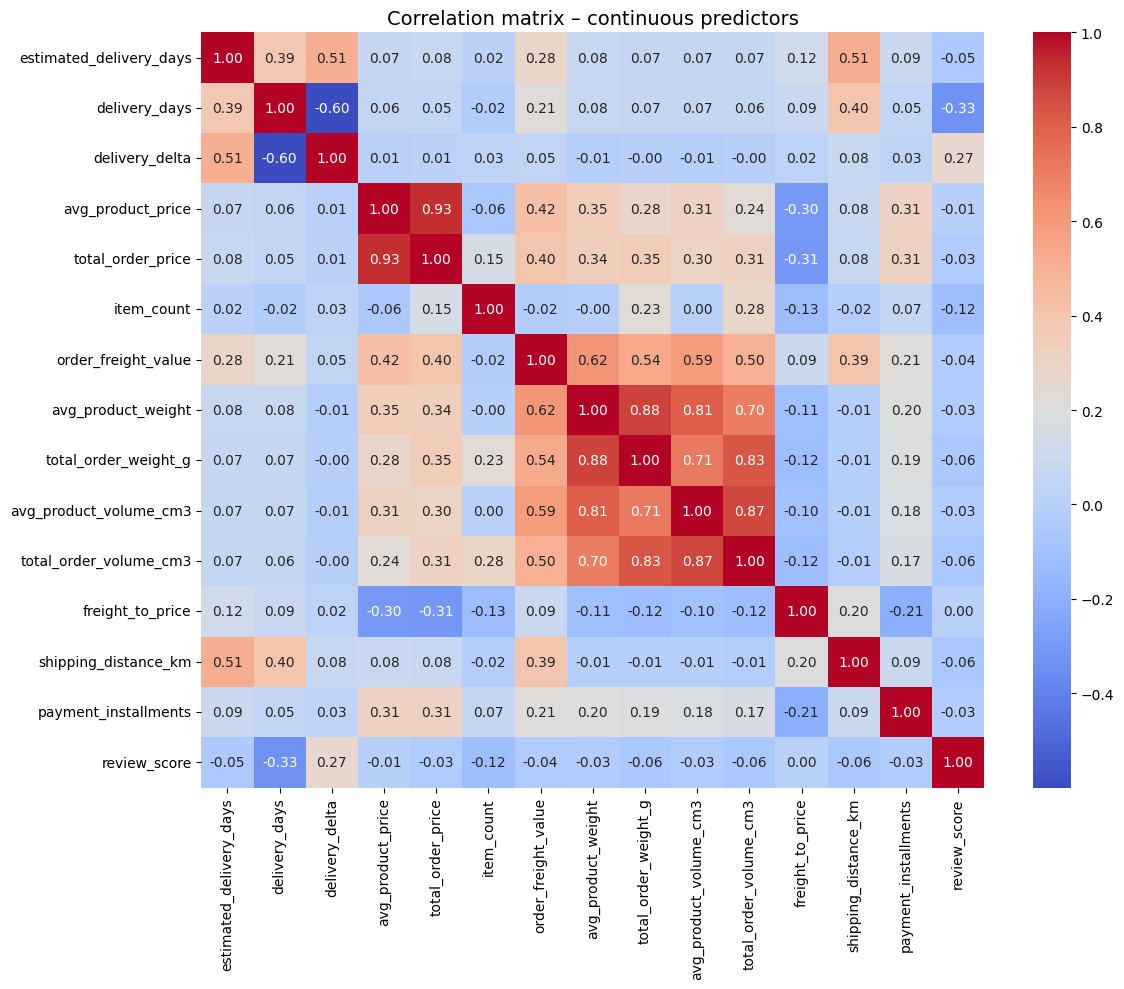

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns


cont_cols = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if (df[c].nunique() >= 3) and c != 'review_score'
]

df_cont = df[cont_cols + ['review_score']].dropna()

corr = df_cont.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f',
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.title('Correlation matrix – continuous predictors', fontsize=14)
plt.tight_layout()
plt.show()



En la matriz de correlación anterior podemos observar que hay algunas variables que tienen correlación con review_score. Pero también podemos ver que hay regresores que tienen alta colinealidad entre ellos. Esto sugiere que el modelo debe ser depurado

In [ ]:

X = df_cont.drop(columns=['review_score'])
y = df_cont['review_score']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)


def backward_elimination(X, y, sl=0.05):
    feats = X.columns.tolist()
    while True:
        model = sm.OLS(y, sm.add_constant(X[feats])).fit()
        pvals = model.pvalues.drop('const')
        worst_p = pvals.max()
        if worst_p > sl:
            feats.remove(pvals.idxmax())
        else:
            return model, feats

be_model, sel_feats = backward_elimination(X_train, y_train)

print("\n=== Resumen del modelo depurado (sin dummies) ===\n")
print(be_model.summary())
print(f"\nVariables seleccionadas: {sel_feats}")

usecols = sel_feats + ['review_score']
clear_df = pd.read_csv('dataset/cleaned_orders.csv', usecols=usecols)


=== Resumen del modelo depurado (sin dummies) ===

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     1339.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:13:27   Log-Likelihood:            -1.2068e+05
No. Observations:               75622   AIC:                         2.414e+05
Df Residuals:                   75612   BIC:                         2.415e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

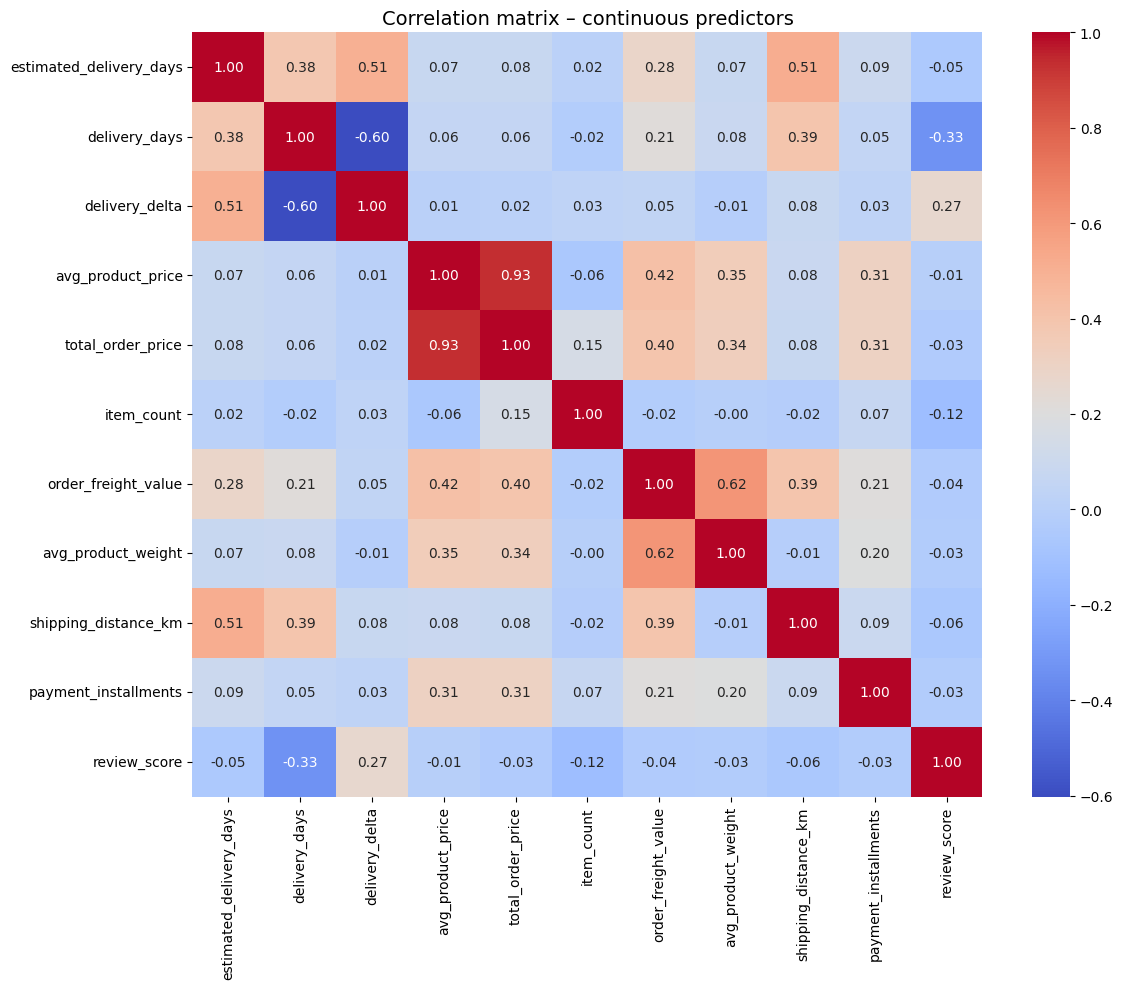

In [ ]:

corr = clear_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f',
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.title('Correlation matrix – continuous predictors', fontsize=14)
plt.tight_layout()
plt.show()



Luego de depurar el modelo, podemos observar que se conservaron las clumnas estimated_delvery_days, delivery_days, delivery_delta, avg_product_price, total_order_price, item_count, order_freight_value, avg_product_weight, shipping_distance_km y payment_installments


RMSE hold‑out: 1.1827
R² hold‑out: 0.1433


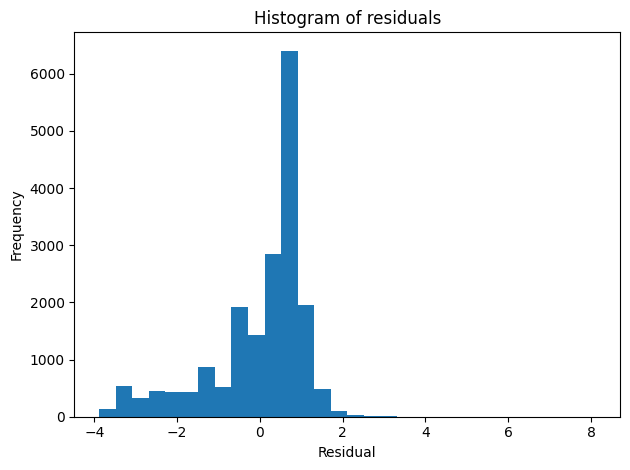

<Figure size 640x480 with 0 Axes>

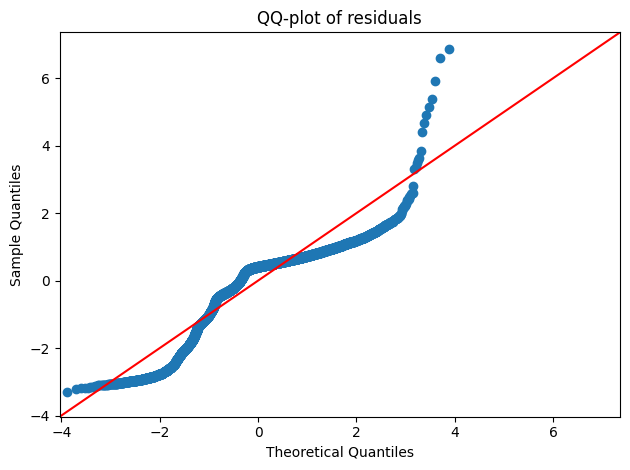

In [35]:

linreg = LinearRegression().fit(X_train[sel_feats], y_train)
y_pred = linreg.predict(X_test[sel_feats])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'\nRMSE hold‑out: {rmse:.4f}')
print(f'R² hold‑out: {r2:.4f}')

residuals = y_test - y_pred

# Histograma de residuales
plt.figure()
plt.hist(residuals, bins=30)
plt.title('Histogram of residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# QQ‑plot
plt.figure()
qqplot(residuals, line='45', fit=True)
plt.title('QQ‑plot of residuals')
plt.tight_layout()
plt.show()

Los errores están centrados en 0 (modelo no sesgado en promedio) pero la distribución es asimétrica y con colas gruesas (kurtosis > 0).

Las colas de la distribución empírica son más pesadas que las de una normal; se confirma la falta de normalidad.

In [ ]:

params = be_model.params
intercept = params['const']
betas = params.drop('const')


eq = f"ŷ = {intercept:.4f}"
for var, coef in betas.items():
    sign = "+" if coef >= 0 else "-"
    eq += f" {sign} {abs(coef):.4f}·{var}"

print("Ecuación del modelo lineal:")
print(eq)


Ecuación del modelo lineal:
ŷ = 4.8121 - 0.0107·estimated_delivery_days - 0.0315·delivery_days + 0.0208·delivery_delta + 0.0003·avg_product_price - 0.0003·total_order_price - 0.2860·item_count + 0.0010·order_freight_value - 0.0000·avg_product_weight + 0.0001·shipping_distance_km - 0.0058·payment_installments


En la parte de arriba podemos observar la ecuación del modelo ya depurado el cual nos maximiza el R² a un 0.137 y un adj-R² de 0.137 de igual forma

## Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor

In [11]:
x_train = dftrain.drop(columns=['review_score'])
y_train = dftrain['review_score']

x_test = dftest.drop(columns=['review_score'])
y_train = dftrain['review_score']

rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 7)

Evaluación del Modelo Random Forest:
Mean Squared Error (MSE): 1.322386
Mean Absolute Error (MAE): 0.887680
R-squared (R²): 0.190096


ValueError: x and y must be the same size

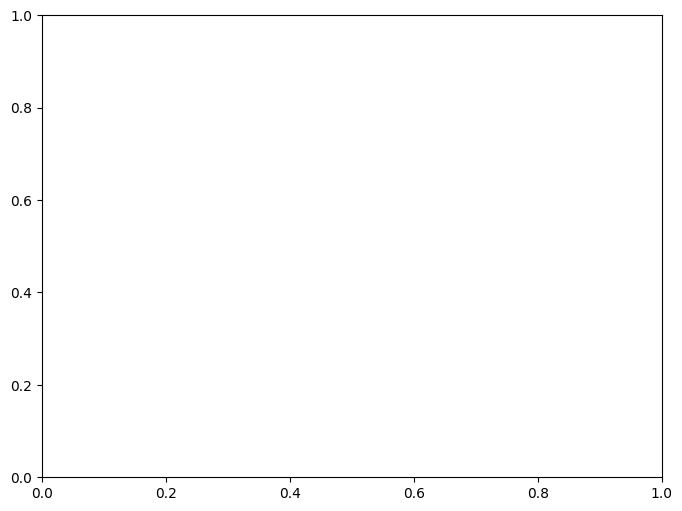

In [12]:
rf_regressor.fit(x_train, y_train)
Y_pred = rf_regressor.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluación del Modelo Random Forest:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, Y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Valores Reales (SalePrice)")
plt.ylabel("Predicciones (SalePrice)")
plt.title("Valores Reales vs Predicciones - Random Forest")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],      # Number of trees
    'max_depth': [None, 10, 20],      # Tree depth
    'min_samples_split': [2, 5],      # Minimum samples to split
}

# Initialize GridSearch
rf_regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Optimization metric
    n_jobs=-1,               # Use all CPU cores
    verbose=2                # Print progress
)

# Run grid search
grid_search.fit(x_train, y_train)

# Get best model
best_rf = grid_search.best_estimator_

# Evaluate
y_pred = best_rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nBest Parameters:", grid_search.best_params_)
print("\nEvaluación del Modelo Random Forest Optimizado:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (SalePrice)")
plt.ylabel("Predicciones (SalePrice)")
plt.title("Valores Reales vs Predicciones - Random Forest Optimizado")
plt.show()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 1.5min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 1.5min
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  33.6s
[CV] END max_depth=10, min_s

## Naive Bayes

## KNN

In [ ]:
# Crear el modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5) 
knn_model.fit(X_train, y_train)

# Predicciones
y_pred_knn = knn_model.predict(X_test)

# Evaluación
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"Resultados KNN Regression:")
print(f"MAE  = {mae_knn:.2f} días")
print(f"RMSE = {rmse_knn:.2f} días")
print(f"R²   = {r2_knn:.4f}")

## SVR

In [ ]:
from sklearn.svm import SVR

# 1. Aplicar muestreo al set de entrenamiento
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=5000, random_state=42)

# 2. Crear el modelo SVR
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr_model.fit(X_train_sample, y_train_sample)

# 3. Predicciones (usamos el test completo para evaluar)
y_pred_svr = svr_model.predict(X_test)

# 4. Evaluación
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f"Resultados SVR (con muestreo de 5000 registros):")
print(f"MAE  = {mae_svr:.2f} días")
print(f"RMSE = {rmse_svr:.2f} días")
print(f"R²   = {r2_svr:.4f}")